# Finetuning SegFormer model on eelgrass and macroalgae

This notebook contain the procedure for loading my custom dataset and finetuning a SegFormer model for semantic segmentation.

My code is adopted from the following codes and documentation and changed to fit my needs.

[HuggingFace SegFormer](https://huggingface.co/docs/transformers/model_doc/segformer)

[How to build dataset - kaggle notebook for drone image segmentation](https://www.kaggle.com/code/italyforever/drone-images-segmentation)

[HuggingFace guide on semantic segmentation](https://huggingface.co/docs/transformers/main/en/tasks/semantic_segmentation)

[Main part of my code comes from this notebook: Tutorial Notebook to Finetune TensorFlow based SegFormer model](https://colab.research.google.com/github/deep-diver/segformer-tf-transformers/blob/main/notebooks/TFSegFormer_Finetune.ipynb)

[metrics - library from HuggingFace](https://huggingface.co/spaces/evaluate-metric)



# My pipeline


*   Create images and masks
*   Mount google drive
*   Install and import dependencies
*   Create dataset
*   Preprocess data
*   Convert into tensorflow compatible dataset
*   Define metrics
*   Build model
*   Train model
*   Save model and metrics (model histories)
*   Evaluate model
*   Inference

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# set path
%cd '/content/gdrive/MyDrive/Speciale'

/content/gdrive/MyDrive/Speciale


In [ ]:
# Install packages
!pip -q install datasets==2.3.2
!pip -q install huggingface-hub
!pip install git+https://github.com/huggingface/transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.3/362.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# A new keras version 3 is released. This do not communicate properly with transformers.To fix, run the following
# error correction from: https://discuss.huggingface.co/t/pretrain-model-not-accepting-optimizer/76209/15

!pip install --upgrade transformers
!pip install tf-keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [ ]:
# Import dependencies

import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from datasets import load_dataset, load_metric
from huggingface_hub import cached_download, hf_hub_url
from tensorflow.keras.optimizers import Adam

from transformers import (
    DefaultDataCollator,
    SegformerFeatureExtractor,
    TFSegformerForSemanticSegmentation,
    create_optimizer,
)
from transformers.keras_callbacks import KerasMetricCallback

import datasets
import glob
from pathlib import Path

import pickle

## Build Data Pipeline

### Create dataset

In [ ]:
# set path to image/mask and create dataset. datatype: PIL images
IMAGES = glob.glob(str(Path('datasets/images/train_val/*.jpg')))
SEG_MAPS = glob.glob(str(Path('datasets/mask/train_val/*.png')))
dataset = datasets.Dataset.from_dict({'pixel_values': IMAGES, 'label': SEG_MAPS}, features=datasets.Features({'pixel_values': datasets.Image(), 'label': datasets.Image()}))

In [ ]:
dataset

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 298
})

In [ ]:
# create id for the labels
id2label = {0: 'background', 1: 'eelgrass', 2: 'macroalgae'}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)
id2label

{0: 'background', 1: 'eelgrass', 2: 'macroalgae'}

In [ ]:
# split dataset into train and validation (testset is randomly extracted and saved in seperate folder)
ds = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = ds['train']
val_ds = ds['test']

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 238
    })
    test: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 60
    })
})

In [ ]:
# test to see if everything looks fine
pixel_values = train_ds[0]['pixel_values']
pixel_values = np.array(pixel_values)
print(pixel_values)

Image data type: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7ACB554973D0> <PIL.PngImagePlugin.PngImageFile image mode=L size=512x512 at 0x7ACB55497FA0>


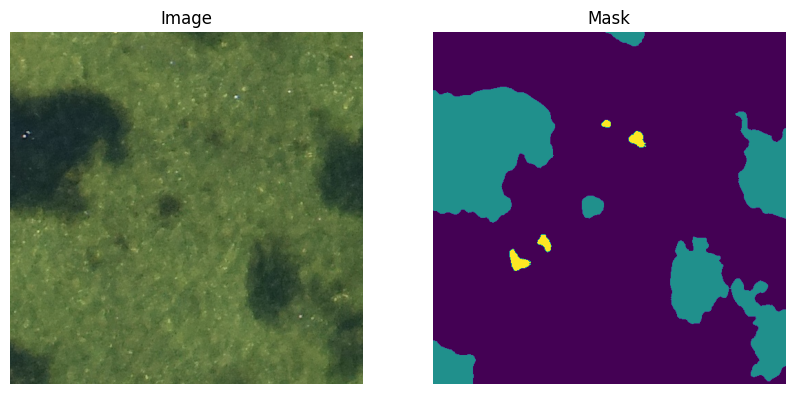

In [ ]:
# check if image and mask correspond to each other

# define an image/mask pair for the test
test_example = val_ds[59]

# Load image/mask
sample_image = test_example["pixel_values"]
sample_mask = test_example["label"]
print("Image data type:", sample_image, sample_mask)

# Plot image/mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(sample_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(sample_mask)
plt.axis("off")

plt.show()

### Transform the dataset


In [ ]:
# functions for preprocessing using SegFormer Feature Extractor
'''
Weird thing are happening here! After much struggle to get the SegFormer model to function correctly, I found that the
feature_extractor did not normalize the images unless I set the do_normalize = false. This do not make any sence!!
The pixel values for the dataset are checked to verify that they infact is in the interval 0 - 1 (please look at the
code two sections below this section).
'''

feature_extractor = SegformerFeatureExtractor(do_normalize=False) # why are the images normalized when setting do_normalize to false?


def transforms(image):
    image = tf.keras.utils.img_to_array(image)
    image = image.transpose((2, 0, 1))
    return image


def preprocess(example_batch):
    images = [transforms(x.convert("RGB")) for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = feature_extractor(images, labels)
    return inputs

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [ ]:
# Preprocess the datasets
train_ds.set_transform(preprocess)
val_ds.set_transform(preprocess)

In [ ]:
# Check that the images are correctly normalized (takes several minutes to run)

# Initialize variables to store max and min pixel values
max_pixel_value = float('-inf')
min_pixel_value = float('inf')

# Iterate over the train dataset
for example in train_ds:
    # Extract pixel values
    pixel_values = example['pixel_values']

    # Calculate the maximum and minimum pixel values for this example
    max_pixel_value_example = tf.reduce_max(pixel_values)
    min_pixel_value_example = tf.reduce_min(pixel_values)

    # Update overall maximum and minimum pixel values
    max_pixel_value = tf.maximum(max_pixel_value, max_pixel_value_example)
    min_pixel_value = tf.minimum(min_pixel_value, min_pixel_value_example)

print('Overall Maximum Pixel Value:', max_pixel_value)
print('Overall Minimum Pixel Value:', min_pixel_value)


Overall Maximum Pixel Value: tf.Tensor(1.0, shape=(), dtype=float32)
Overall Minimum Pixel Value: tf.Tensor(0.0, shape=(), dtype=float32)


### Convert Dataset into TensorFlow compatible dataset

In [ ]:
# Define batch size
batch_size = 6

In [ ]:
# Use the datacollator to convert to tensorflow compatible dataset

data_collator = DefaultDataCollator(return_tensors="tf")
np.bool = np.bool_ # quick and dirty trick to avoid error

train_set = train_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

val_set = val_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

In [ ]:
# Look at the shapes of each features within the dataset.
train_set.element_spec

{'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.int64, name=None),
 'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None)}

In [ ]:
# Investigate a single batch.
batch = next(iter(train_set))
batch["pixel_values"].shape, batch["labels"].shape

(TensorShape([6, 3, 512, 512]), TensorShape([6, 512, 512]))

## Build Model

### Use KerasMetricCallback from HuggingFace Dataset to compute metrics

In [ ]:
# mean_iou is a library from hugginface that returns a dict of metrics
metric = load_metric("mean_iou")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits are of shape (batch_size, num_labels, height, width), so
    # we first transpose them to (batch_size, height, width, num_labels)
    logits = tf.transpose(logits, perm=[0, 2, 3, 1])
    # scale the logits to the size of the label
    logits_resized = tf.image.resize(
        logits,
        size=tf.shape(labels)[1:],
        method="bilinear",
    )
    # compute the prediction labels and compute the metric
    pred_labels = tf.argmax(logits_resized, axis=-1)
    metrics = metric.compute(
        predictions=pred_labels,
        references=labels,
        num_labels=num_labels,
        ignore_index=None, # ignore_index=-1 is used if calculation should not include background class
        reduce_labels=feature_extractor.do_reduce_labels,
    )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update(
        {f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)}
    )
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return {"val_" + k: v for k, v in metrics.items()}


metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=val_set,
    batch_size=batch_size,
    label_cols=["labels"],
)

### Build model

In [ ]:
# set parameters
epochs = 50
lr = 0.00004

In [ ]:
# Define model
model_checkpoint = "nvidia/mit-b0"
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)

# compile model
optimizer = Adam(learning_rate=lr)
model.compile(optimizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  3319392   
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  396035    
 codeHead)                                                       
                                                                 
Total params: 3715427 (14.17 MB)
Trainable params: 3714915 (14.17 MB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


In [ ]:
# Dummy forward pass.
tf.config.run_functions_eagerly(True)  # Disable re-tracing for debugging
outputs = model(batch)
outputs.loss, outputs.logits.shape

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.0313998], dtype=float32)>,
 TensorShape([6, 3, 128, 128]))

### Train the model

In [ ]:
callbacks = [metric_callback]

In [ ]:
# Train the model

model.fit(
    train_set,
    validation_data=val_set,
    callbacks=callbacks,
    epochs=epochs,
)

In [ ]:
# save the model

model_path = 'models/30'
model.save_pretrained(model_path)

In [ ]:
# save metrics in the form of model_history

file_path = 'model_history/30.pkl'

with open(file_path, 'wb') as file:
  pickle.dump(model.history.history, file)

In [ ]:
# load file history

with open('model_history/30.pkl', 'rb') as file:
  test_history = pickle.load(file)

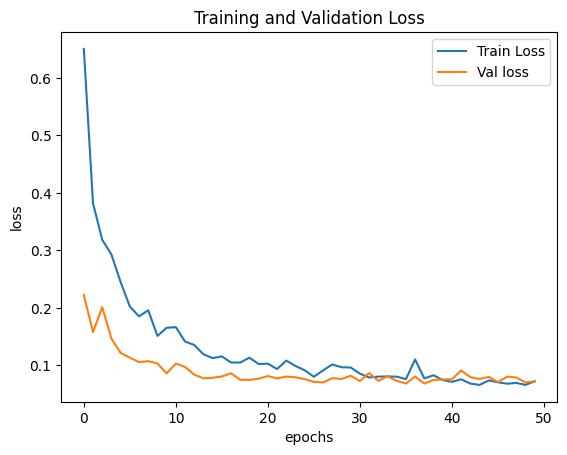

In [ ]:
# plot history from saved metrics

loss = test_history['loss']
val_loss = test_history['val_loss']

plt.plot(test_history['loss'], label = 'Train Loss')
plt.plot(test_history['val_loss'], label = 'Val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

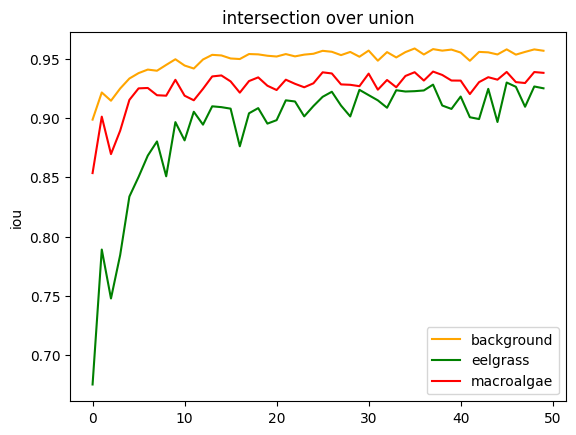

In [ ]:
# plot history from saved metrics

plt.plot(test_history['val_iou_background'], label = 'background', color= 'orange')
plt.plot(test_history['val_iou_eelgrass'], label = 'eelgrass', color ='green')
plt.plot(test_history['val_iou_macroalgae'], label = 'macroalgae', color = 'red')
plt.ylabel('iou')
plt.title('intersection over union')
plt.legend()
plt.show()

## Evaluate the model

Now that we have seen how we can fine-tune the SegFormer model it's time to see how to evaluate it. For this purpose, we'll use a model that was trained for 50 epochs using the exact same code.

In [ ]:
# Load the finetuned model as pretrained_model
finetuned_model_ckpt = 'models/30'
pretrained_model = TFSegformerForSemanticSegmentation.from_pretrained(
    finetuned_model_ckpt
)

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at models/30.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


In [ ]:
# compile the model and use the validation dataset to calculate loss
pretrained_model.compile()
eval_loss = pretrained_model.evaluate(val_set)
eval_loss

6/6 [==============================] - 7s 997ms/step - loss: 0.1435


0.1434747725725174

## Inference

In [ ]:
# Load dataset
ds = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = ds['train']
val_ds = ds['test']

In [ ]:
# inference on the validation dataset
inference = ds['test'] # val_ds = ds["test"]

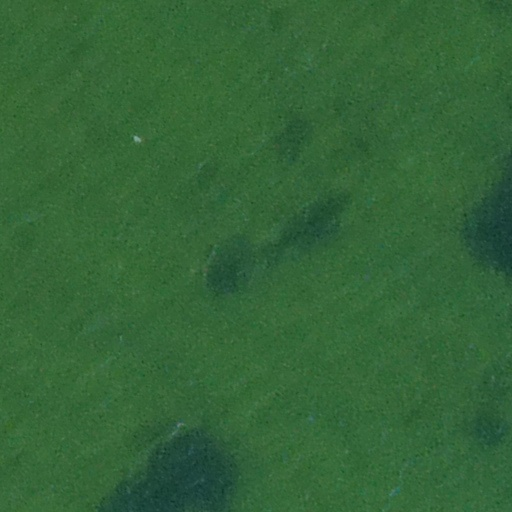

In [ ]:
# show a test image
test_image = inference[31]['pixel_values']
test_gt = inference[31]['label']
test_image

In [ ]:
# extract features for the test image
inputs = feature_extractor(images=test_image, return_tensors="tf")
print(inputs['pixel_values'].shape)

(1, 3, 512, 512)


In [ ]:
# load data from pretrained model, appy the model to an image, resize the logits to fit the original size of the image/mask

outputs = pretrained_model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# Transpose to have the shape (batch_size, height/4, width/4, num_labels)
logits = tf.transpose(logits, [0, 2, 3, 1])

# First, rescale logits to original image size
upsampled_logits = tf.image.resize(
    logits,
    test_image.size[
        ::-1
    ],  # We reverse the shape of `image` because `image.size` returns width and height.
)

# Second, apply argmax on the class dimension
pred_seg = tf.math.argmax(upsampled_logits, axis=-1)[0]
print(pred_seg.shape)

(512, 512)


In [ ]:
# Define a palette to color the three classes

def get_palette():
    """palette that maps each class to RGB values."""
    return [
        [255, 255, 0],
        [0, 255, 0],
        [255, 0, 0]
    ]

In [ ]:
# create function to overlay mask and image

def get_seg_overlay(image, seg):
    color_seg = np.zeros(
        (seg.shape[0], seg.shape[1], 3), dtype=np.uint8
    )  # height, width, 3
    palette = np.array(get_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    return img

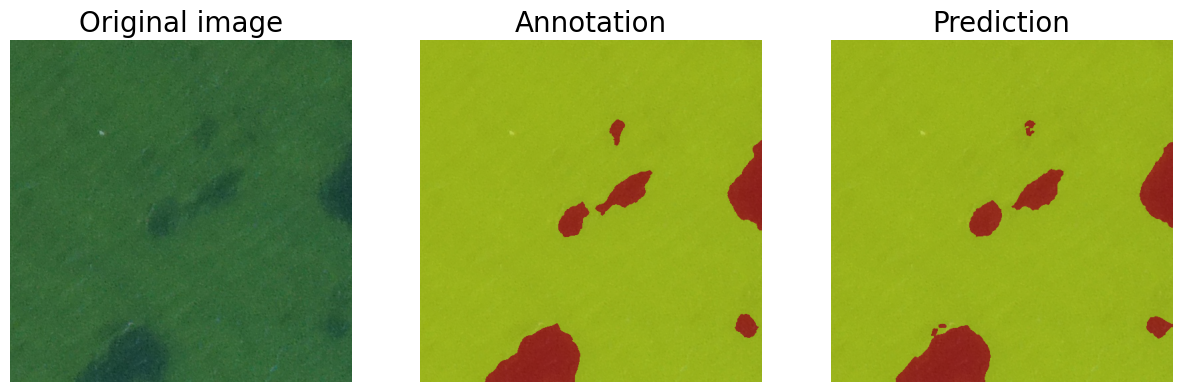

In [ ]:
pred_img = get_seg_overlay(test_image, pred_seg.numpy())
gt_img = get_seg_overlay(test_image, np.array(test_gt))

f, axs = plt.subplots(1, 3)
f.set_figheight(15)
f.set_figwidth(15)

axs[0].set_title('Original image', {'fontsize': 20})
axs[0].imshow(test_image)
axs[0].axis('off')
axs[1].set_title('Annotation', {'fontsize': 20})
axs[1].imshow(gt_img)
axs[1].axis('off')
axs[2].set_title('Prediction', {'fontsize': 20})
axs[2].imshow(pred_img)
axs[2].axis('off')

plt.show()